In [1]:
import scanpy as sc
import os
import requests
from tqdm import tqdm
from anndata import AnnData as ad
import pandas as pd

In [2]:
from celldreamer.paths import DATA_DIR

Read dataset 

In [3]:
def load_dataset(path, url, new_name=None):
    # Check if the file exists at the specified path
    if not os.path.exists(path):
        # If not, download the file from the URL
        print(f"Dataset not found at {path}. Downloading from {url}...")
        response = requests.get(url, stream=True)
        
        # Get the total file size for progress bar
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kilobyte

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")
        
        print("Download complete.")
    
    # Rename the dataset file if new_name is provided
    if new_name:
        os.rename(path, new_name)
        path = new_name

    # Load the dataset using Scanpy
    dataset = sc.read_h5ad(path)
    return dataset

dataset_path = os.path.join(DATA_DIR, 'raw', 'hlca_core.h5ad')
dataset_url = 'https://datasets.cellxgene.cziscience.com/7a3f08f9-5d07-4ddd-a8fe-5967dd34f35f.h5ad'

adata = load_dataset(path=dataset_path, url=dataset_url, new_name=dataset_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 584944 × 28024
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

Save counts 

In [5]:
adata.layers["X_counts"] = adata.X.copy()

HVG selection

In [6]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=True,
)

Preprocess

In [7]:
sc.pp.log1p(adata)

In [8]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


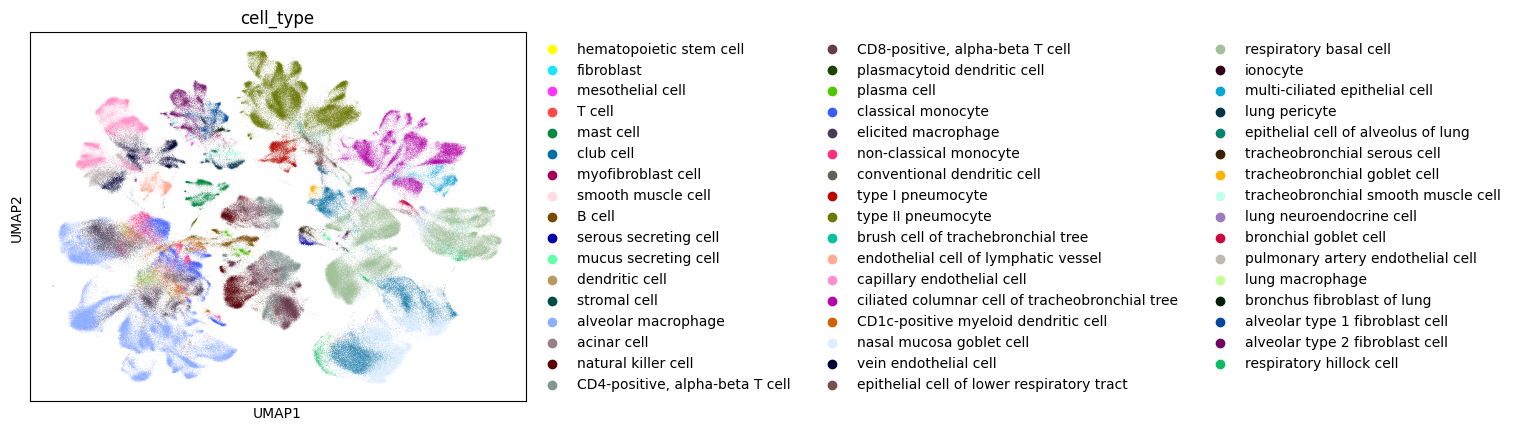

In [9]:
sc.pl.umap(adata, color=["cell_type"])

In [10]:
adata

AnnData object with n_obs × n_vars = 584944 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

Save

In [11]:
processed_dataset_path = os.path.join(DATA_DIR, 'processed', 'hlca_core.h5ad')

ad.write_h5ad(adata, processed_dataset_path)

In [12]:
adata.obs["lib_size"] = adata.layers["X_counts"].A.sum(1)

In [13]:
adata.obs.lib_size

GCGACCATCCCTAACC_SC22      286.935272
P2_1_GCGCAACCAGTTAACC      240.049118
GCTCTGTAGTGCTGCC_SC27      141.506287
P2_8_TTAGGACGTTCAGGCC      316.501831
CTTGATTGTCAGTTTG_T164      223.632538
                              ...    
ACCTTTACATTAACCG_T120      256.120544
CATTATCTCCATGAAC_F01639    336.034912
AGGCCGTGTGTGACCC-SC56      238.414062
CGATGGCAGCAGGCTA-1-2       202.846207
AATCGGTGTCGGCACT-1-4       149.637787
Name: lib_size, Length: 584944, dtype: float32

In [14]:
adata.obs.groupby("cell_type").lib_size.mean()

cell_type
hematopoietic stem cell                            156.034668
fibroblast                                         301.223999
mesothelial cell                                   259.520630
T cell                                             191.702377
mast cell                                          213.871399
club cell                                          186.528961
myofibroblast cell                                 210.756744
smooth muscle cell                                 235.184875
B cell                                             168.235413
serous secreting cell                              210.505417
mucus secreting cell                               177.412537
dendritic cell                                     243.116379
stromal cell                                       159.775345
alveolar macrophage                                297.112732
acinar cell                                        221.992340
natural killer cell                                212.61947